In [12]:
from transform import *
from data import *
from model import *

In [13]:
path_300w = '/home/whale/dataset/Landmark/300W'
path_300w_lp = '/home/whale/dataset/Landmark/300W_LP'
path_train = os.path.join(path_300w, "train.xml")
path_test = os.path.join(path_300w, "test.xml")
path_all = os.path.join(path_300w, "all.xml")
path_lp = os.path.join(path_300w_lp, "all.txt")
composed = transforms.Compose([CropByLDK(1.4),
                               Flip(),
                               #Rotate(30),
                               #Gnoise(),
                               RandomCrop(),
                               Rescale((64,64)),
                               ToTensor(),
                               Normalize()
                               ])
test = Ldk_300W_Dataset(path_test, path_300w, composed)
#inall = Ldk_300W_Dataset(path_all,path_300w)
#train = Ldk_300W_Dataset(path_train, path_300w)
#test = Ldk_300W_Dataset(path_test, path_300w, composed)
#lp = Ldk_300W_LP_Dataset(path_lp, path_300w_lp, composed)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net= MobileNetV2()
net.to(device) 

16 24 2 6
24 24 1 6
24 32 2 6
32 32 1 6
32 64 2 6
64 64 1 6


MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False)
        (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
        (6): Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(24, 1

In [15]:
import torch.optim as optim
from tensorboardX import SummaryWriter
writer = SummaryWriter(log_dir='logs')
criterion = torch.nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

dataset = Ldk_300W_LP_Dataset(path_lp, path_300w_lp, composed)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)
for i in range(10):
    for i_batch, sample_batched in enumerate(dataloader):
        inputs, labels = sample_batched['image'].to(device), sample_batched['landmarks'].to(device)
        outputs = net(inputs)
        labels = labels.view(-1, 136)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i_batch % 500 == 0:
            writer.add_scalar('Loss',loss.item(),i_batch + i * i_batch)
writer.close()

/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/whale/.local/lib/python2.7/sit

KeyboardInterrupt: 

/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled 

tensor([[0.8560, 0.3199, 0.8473,  ..., 0.6701, 0.5336, 0.6666],
        [0.8592, 0.2590, 0.8543,  ..., 0.6094, 0.4585, 0.5999],
        [0.8444, 0.3036, 0.8433,  ..., 0.6284, 0.6243, 0.6231],
        ...,
        [0.8574, 0.3565, 0.8530,  ..., 0.7044, 0.5410, 0.6969],
        [0.8140, 0.3884, 0.8235,  ..., 0.6635, 0.6873, 0.6648],
        [0.8313, 0.2660, 0.8465,  ..., 0.6172, 0.6402, 0.6071]],
       device='cuda:0', grad_fn=<AddmmBackward>)


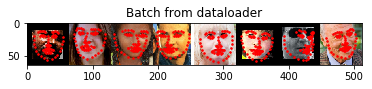

In [23]:
dataloader = DataLoader(test, batch_size=8, shuffle=True, num_workers=4)
for i_batch, sample_batched in enumerate(dataloader):
    inputs, labels = sample_batched['image'].to(device), sample_batched['landmarks'].to(device)
    outputs = net(inputs)
    print outputs
    outputs = (outputs.view(-1,68,2) * 64).cpu().detach()
    batch = {'image':sample_batched['image'], 'landmarks':outputs}
    show_landmarks_batch(batch)
    break

In [10]:
state = {'net':net.state_dict()}
torch.save(state, "/home/whale/workspace/torch/mobile-landmark/landmark.pth")

In [11]:
model = torch.load("/home/whale/workspace/torch/mobile-landmark/landmark.pth")['net']